In [1]:
# cd("/home/xinhou/radPV/")
include("helper.jl");

### Region overview

In [2]:
lon = ncread(fnGr, "lon")
lat = ncread(fnGr, "lat");

In [3]:
grid = zeros(16,16);
grid[1:4,1:3] .= 1 # Iberia
grid[13:16,1:3] .= 2 # Balkans
grid[7:10, 5:6] .= 3; # central EU

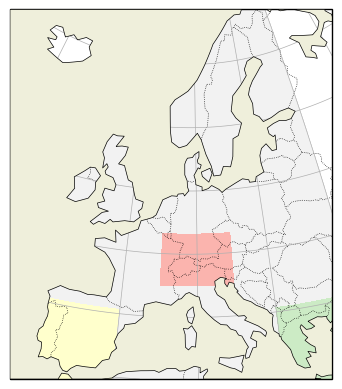

PyObject <matplotlib.collections.QuadMesh object at 0x7f5921704350>

In [4]:
ax = plt.subplot(1,1,1, projection=proj3)
ax.gridlines(linewidth=.5)
ax.add_feature(cfeature.BORDERS, linewidth=.5, linestyle=":") 
ax.add_feature(cfeature.OCEAN, zorder=100, edgecolor="k", lw=.5, facecolor=cfeature.COLORS["land"]) 
wrap_data, wrap_lon = cput.add_cyclic_point(grid[:,:]', coord=lon, axis=1)
p = ax.pcolormesh(wrap_lon, lat, wrap_data, transform=proj1, cmap="Pastel1_r") 

### PV curves

In [5]:
areaIbe = area[1:4,1:3] # Iberia
areaBal = area[13:16,1:3] # Balkans
areaCEU = area[7:10, 5:6]; # central EU
# area weighting
areaWeiIbe = areaIbe ./ sum(areaIbe)
areaWeiBal = areaBal ./ sum(areaBal)
areaWeiCEU = areaCEU ./ sum(areaCEU)

4×2 Array{Float64,2}:
 0.12785  0.12215
 0.12785  0.12215
 0.12785  0.12215
 0.12785  0.12215

In [6]:
# average m x n grids to 1 area
pvMn(pv, areaWei) = dropdims(sum(pv .* areaWei; dims=(1,2)); dims=(1,2))

pvMn (generic function with 1 method)

In [7]:
function pvArrM(m, s) # model, ssp
    pathPv = joinpath(myPath, "pv", ssps[s], "day/EU/tilt_lat/regr/ymonMn")
    rmcp(pathPv)
    fnam = joinpath(pathPv, readdir(pathPv)[m])
    pv = ncread(fnam, "pv")[:,:,:];

    pvWest = pv[1:4,1:3,:]
    pvEast = pv[end-3:end,1:3,:] 
    pvCen = pv[7:10,5:6,:]
    
    pvWestMatr = getPvMatrix(pvMn(pvWest, areaWeiIbe))
    pvEastMatr = getPvMatrix(pvMn(pvEast, areaWeiBal))
    pvCenMatr = getPvMatrix(pvMn(pvCen, areaWeiCEU))
    return avg.([pvWestMatr, pvEastMatr, pvCenMatr]; n=2)
end

pvArrM (generic function with 1 method)

In [8]:
pvLs = [:pvWestH, :pvEastH, :pvCenH,
        :pvWest1, :pvEast1, :pvCen1,
        :pvWest5, :pvEast5, :pvCen5];

In [9]:
for pv in pvLs
    @eval $pv = zeros(12, 28)
end

In [10]:
for m in 1:28
    pvWestH[:,m], pvEastH[:,m], pvCenH[:,m] = pvArrM(m,1)
    pvWest1[:,m], pvEast1[:,m], pvCen1[:,m] = pvArrM(m,2)
    pvWest5[:,m], pvEast5[:,m], pvCen5[:,m] = pvArrM(m,5)
end

In [11]:
pvArrMn = [avg(eval(arr); n=2) ./1000 for arr in pvLs];

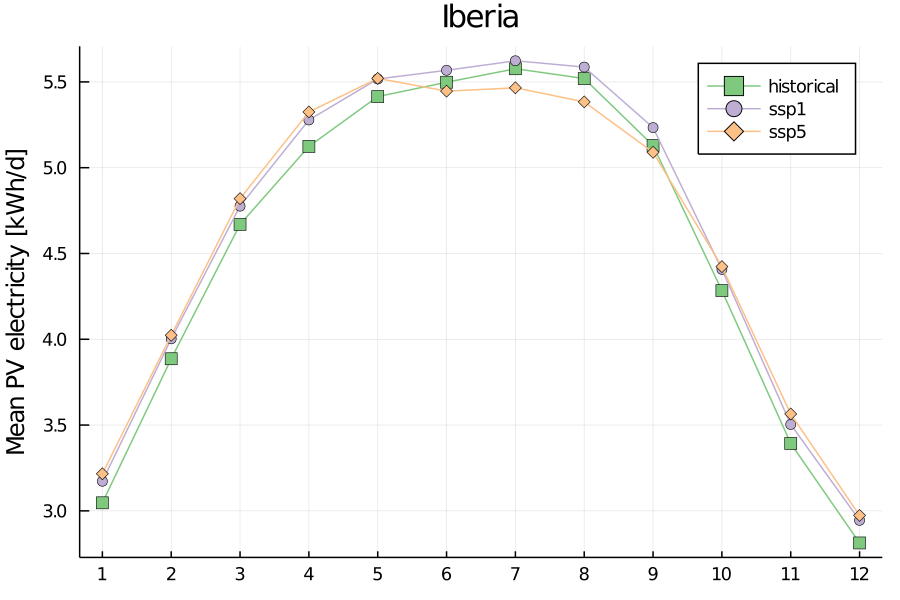

In [12]:
mo = 1:12;
pWest = Plots.plot(mo, pvArrMn[1], label="historical", title="Iberia", xticks=1:12, palette=:Accent_3, 
             marker=:rect, markerstrokewidth=0.5, ylabel="Mean PV electricity [kWh/d]")
plot!(pvArrMn[4], label="ssp1", marker=:circle, markerstrokewidth=0.5) 
plot!(pvArrMn[7], label="ssp5", marker=:diamond, markerstrokewidth=0.5, fmt=:png) #, dpi=150)

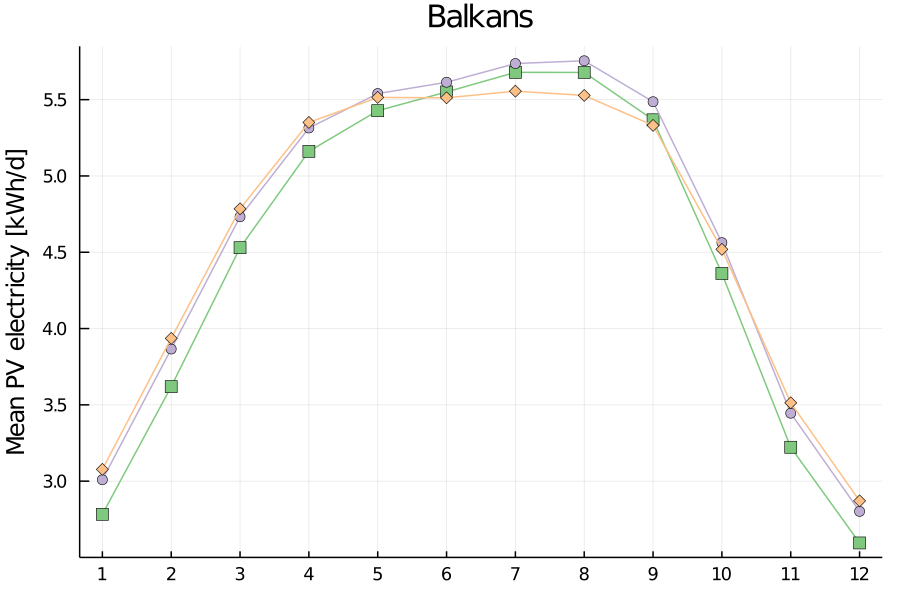

In [13]:
pEast = Plots.plot(mo, pvArrMn[2], label="historical", title="Balkans", xticks=1:12, palette=:Accent_3, legend=false,  
             marker=:rect, markerstrokewidth=0.5, ylabel="Mean PV electricity [kWh/d]")
plot!(pvArrMn[5], label="ssp1", marker=:circle, markerstrokewidth=0.5) 
plot!(pvArrMn[8], label="ssp5", marker=:diamond, markerstrokewidth=0.5, fmt=:png) #, dpi=150)

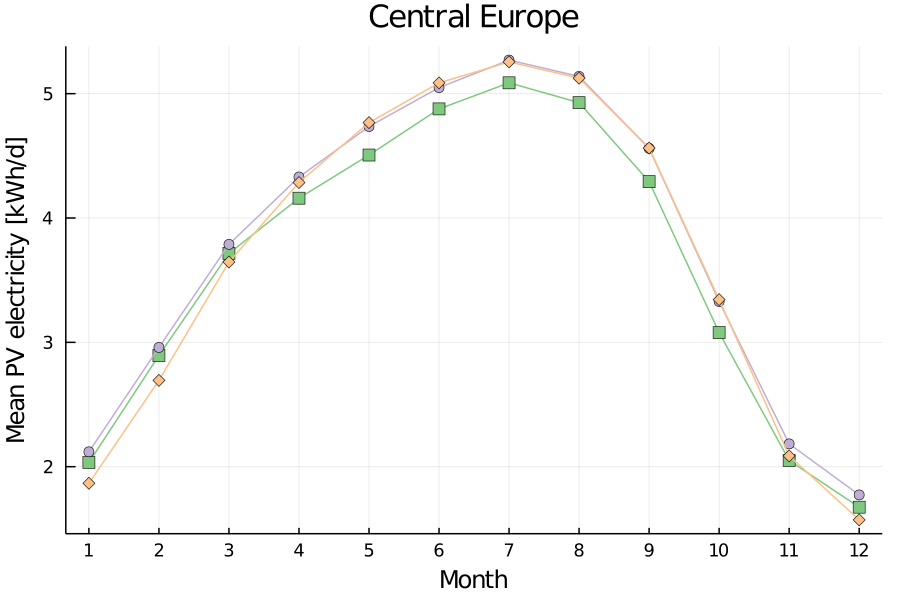

In [14]:
pCEU = Plots.plot(mo, pvArrMn[3], label="historical", title="Central Europe", xticks=1:12, palette=:Accent_3, legend=false,  
             marker=:rect, markerstrokewidth=0.5, ylabel="Mean PV electricity [kWh/d]", xlabel="Month")
plot!(pvArrMn[6], label="ssp1", marker=:circle, markerstrokewidth=0.5) 
plot!(pvArrMn[9], label="ssp5", marker=:diamond, markerstrokewidth=0.5, fmt=:png) #c, dpi=150)

### SpaCorr Ibe & Bal

In [15]:
# get 2 pv series
function get2series(s, m, op) # options: 0 for West & East, 1 for West & Central, 2 for East & Central
    pv = getArr("pv", s, m)
    pvW = pv[1:4,1:3,:]
    pvE = pv[end-3:end,1:3,:]
    pvC = pv[7:10,5:6,:]
    
    if op == 0
        return getPvMatrix(pvMn(pvW, areaWeiIbe)), getPvMatrix(pvMn(pvE, areaWeiBal)) 
    elseif op == 1
        return getPvMatrix(pvMn(pvW, areaWeiIbe))[:], getPvMatrix(pvMn(pvC, areaWeiCEU))[:] 
    elseif op == 2
        return getPvMatrix(pvMn(pvE, areaWeiBal))[:], getPvMatrix(pvMn(pvC, areaWeiCEU))[:]
    end
end

get2series (generic function with 1 method)

In [16]:
Anom(arr) = (arr .- mean(arr, dims=2)) ./ std(arr, dims=2)

Anom (generic function with 1 method)

In [17]:
function pvArrAnomSeas(s,m)
    pvWestMatr, pvEastMatr = get2series(s,m,0)

    size(pvWestMatr,1) == 365 ? 
        (idxSum, idxWin) = (152:243, [1:59; 365-30:365]) :
        (idxSum, idxWin) = (179:30*9-2, [1:58; 358-29:358])
    
    wSum, wWin = pvWestMatr[idxSum,:], pvWestMatr[idxWin,:]
    eSum, eWin = pvEastMatr[idxSum,:], pvEastMatr[idxWin,:]

    return Anom(wSum)[:], Anom(eSum)[:], Anom(wWin)[:], Anom(eWin)[:]
end

pvArrAnomSeas (generic function with 1 method)

In [18]:
function CorrOwnAnomSeas20yr(s) # ssp
    corrSum, corrWin = zeros(28), zeros(28)
    for m in 1:28
        println(m)
        wSumAnom, eSumAnom, wWinAnom, eWinAnom = pvArrAnomSeas(s,m)

        corrSum[m] = cor(wSumAnom, eSumAnom)
        corrWin[m] = cor(wWinAnom, eWinAnom)
    end
    return corrSum, corrWin
end

CorrOwnAnomSeas20yr (generic function with 1 method)

In [19]:
corrhSum20yr, corrhWin20yr = CorrOwnAnomSeas20yr(1)
corr1Sum20yr, corr1Win20yr = CorrOwnAnomSeas20yr(2)
corr5Sum20yr, corr5Win20yr = CorrOwnAnomSeas20yr(5);

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


In [20]:
scens = ["historical", "ssp1", "ssp5"];
leg = ["summer", "winter"];
corSum = [corrhSum20yr, corr1Sum20yr, corr5Sum20yr];
corWin = [corrhWin20yr, corr1Win20yr, corr5Win20yr];

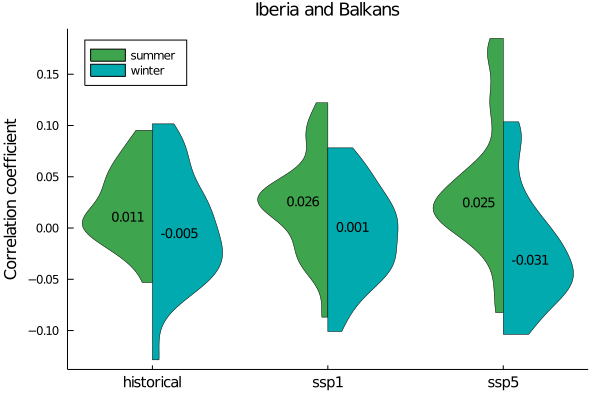

In [21]:
ep = 0.05 # padding
StatsPlots.plot(xtickfont=font(10), fmt=:png) #, dpi=150)

xstart = 0.5
for i in 1:3
    corr = corSum[i]
    md = round(median(corr); digits=3)
    annotate!([(xstart-ep,md, StatsPlots.text(md,9,:right))])
    xstart += 1
    violin!(repeat([scens[i]], outer=28), corr, linewidth=0.5, side=:left, color=3, label="", legend=:topleft, grid=:false)
end
plot!(Shape([],[]),color=3,label=leg[1])

xstart = 0.5
for i in 1:3
    corr = corWin[i]
    md = round(median(corr); digits=3)
    annotate!([(xstart+ep,md, StatsPlots.text(md,9,:left))])
    xstart += 1
    violin!(repeat([scens[i]], outer=28), corr, linewidth=0.5, side=:right, color=6, label="", titlefontsize=12) 
end
plot!(Shape([],[]),color=6,label=leg[2])

title!("Iberia and Balkans")
ylabel!("Correlation coefficient")

### SpaCorr

In [22]:
function corMdl(s)
    corIbe, corBal = zeros(28), zeros(28)
    for m in 1:28
        println(m)
        pv1, pv2 = get2series(s, m, 1)
        pv3, pv4 = get2series(s, m, 2)
        corIbe[m] = cor(pv1, pv2)
        corBal[m] = cor(pv3, pv4)
    end
    return corIbe, corBal
end

corMdl (generic function with 1 method)

In [23]:
corhIbe, corhBal = corMdl(1)
cor1Ibe, cor1Bal = corMdl(2)
cor5Ibe, cor5Bal = corMdl(5)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


([0.6573656826976343, 0.6611623383008172, 0.6366914211318243, 0.5931936391786703, 0.5735359065298994, 0.5225530520621671, 0.5478875748822487, 0.5836323690986182, 0.552508377479293, 0.6875487322937253  …  0.6736244489218455, 0.46531067300654566, 0.5319149933068782, 0.607166116797023, 0.6402903778521956, 0.566154306772932, 0.6332664167182926, 0.6289579384086844, 0.612959696154281, 0.6502336726334698], [0.7021126390703523, 0.7311065674185003, 0.6778041873579761, 0.6194277173170034, 0.5990148564732519, 0.6392397670477276, 0.5347293435097169, 0.5224165260866213, 0.5220412200525426, 0.7108085032360302  …  0.7180667868858788, 0.4798648556999592, 0.5322006485470681, 0.6585407375862394, 0.6931467604712904, 0.5879603417286414, 0.6536978994348837, 0.6081129932651294, 0.6246687713333031, 0.6787416939482934])

In [24]:
cor1difIbe = cor1Ibe - corhIbe
cor5difIbe = cor5Ibe - corhIbe
corDifIbe = vcat(cor1difIbe, cor5difIbe);

In [25]:
cor1difBal = cor1Bal - corhBal
cor5difBal = cor5Bal - corhBal
corDifBal = vcat(cor1difBal, cor5difBal);

In [26]:
mdls = [split(readdir(pathPv)[m], "_")[6] for m in 1:28]
models = repeat(mdls, outer=2); 

scenario = repeat(["ssp1", "ssp5"], inner=28)
titles = ["Iberia and Central Europe", "Balkans and Central Europe"];

In [27]:
p1 = groupedbar(models, corDifIbe, group=scenario, linewidth=0, width=0, grid=false, ylabel="ΔCorr", title=titles[1],
           c=[ColorSchemes.Accent_3[2] ColorSchemes.Accent_3[3]], legend=:bottomright, fmt=:png, #size=(850,600), dpi=150, 
           xrotation=45, xticks=(1:28, mdls), xtickfont=font(8), labelfontsize=font(9))
hline!([mean(cor1difIbe),mean(cor5difIbe)], line = (:dash, [:purple, :orange]), label=false);

In [28]:
p2 = groupedbar(models, corDifBal, group=scenario, linewidth=0, width=0, grid=false, ylabel="ΔCorr", title=titles[2],
           c=[ColorSchemes.Accent_3[2] ColorSchemes.Accent_3[3]], legend=false, fmt=:png, 
           xrotation=45, xticks=(1:28, mdls), xtickfont=font(8), labelfontsize=font(9))
hline!([mean(cor1difBal),mean(cor5difBal)], line = (:dash, [:purple, :orange]), label=false);

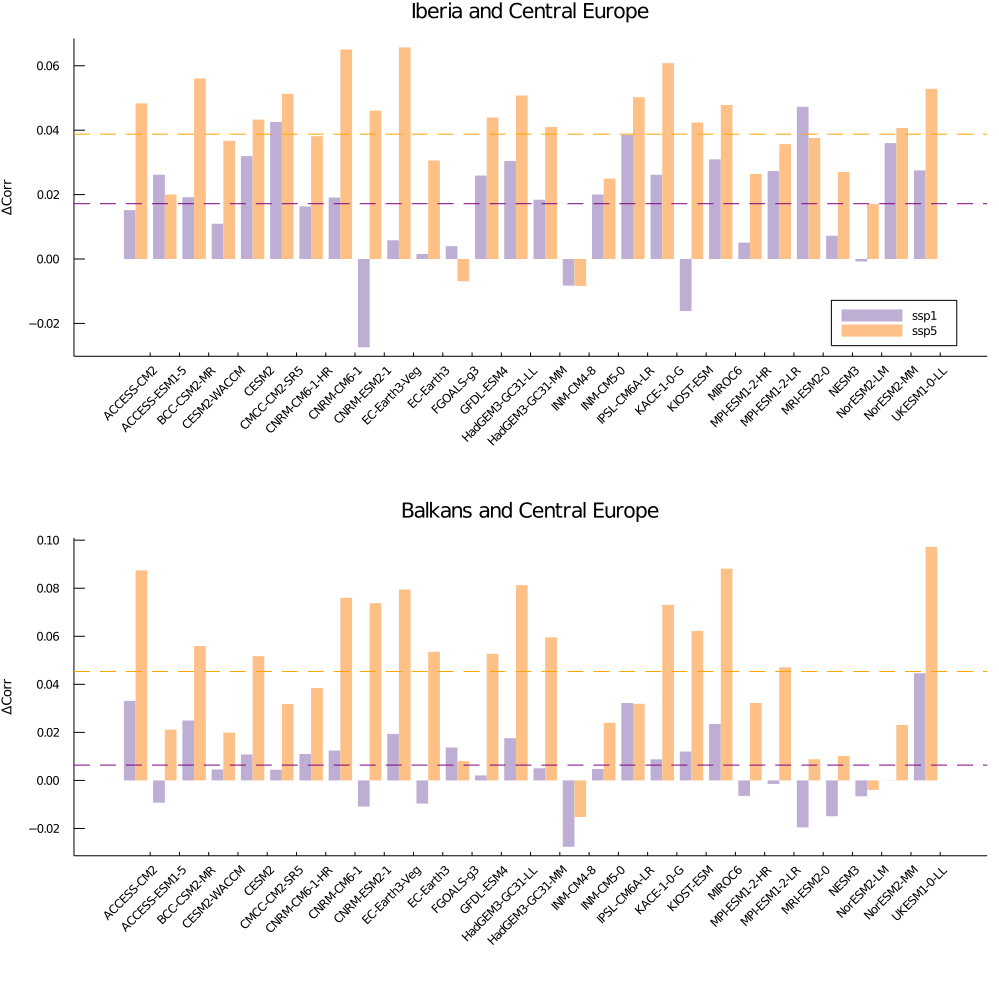

In [29]:
l = @layout [a; b]
Plots.plot(p1, p2, layout=l, size=(1000,1000))

### Tab values

In [30]:
using DataFrames, DataStructures

In [31]:
# round entries in an array to n digits
rd(arr, n) = round.(arr; digits=n)

rd (generic function with 1 method)

In [32]:
ibe1, ibe5, bal1, bal5 = rd.([cor1difIbe, cor5difIbe, cor1difBal, cor5difBal], 3);

In [33]:
# calculate standard deviation of PV power in two locations when balancing using the factor α
bal(α, pv1, pv2) = std(α * pv1 .+ (1-α) * pv2)

bal (generic function with 1 method)

In [34]:
getAlphaMin(stdDevSeries) = findfirst(isequal(minimum(stdDevSeries)), stdDevSeries)

getAlphaMin (generic function with 1 method)

In [35]:
rng = 0.01:0.01:1; # range 0.01 to 1 with interval 0.01

In [36]:
function balancing(s, op) 
    # scenarios: 2 for ssp1 or 5 for ssp5; options: 1 for Iberia or else Balkans with Central Europe
    alpha, stdD = zeros(28), zeros(28)
    for m in 1:28
        println(m)        
        pv1, pv2 = get2series(s, m, 1)
        pv3, pv4 = get2series(s, m, 2)
        op == 1 ?
            stdDevs = [bal(α, pv1, pv2) for α in rng] :
            stdDevs = [bal(α, pv3, pv4) for α in rng]
        αₘ = getAlphaMin(stdDevs)
        alpha[m] = αₘ * 0.01
        stdD[m] = stdDevs[αₘ]
    end
    return alpha, stdD # standard deviation
end

balancing (generic function with 1 method)

In [37]:
alpha1Ibe, std1Ibe = balancing(2, 1)
alpha5Ibe, std5Ibe = balancing(5, 1)

alpha1Bal, std1Bal = balancing(2, 2)
alpha5Bal, std5Bal = balancing(5, 2);

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


In [38]:
al1Ib, al5Ib, al1Ba, al5Ba = rd.([alpha1Ibe, alpha5Ibe, alpha1Bal, alpha5Bal], 2);

In [39]:
# convert standard deviation entries in an array to integers
std2Int(ar) = Int16.(rd(ar, 0))

std2Int (generic function with 1 method)

In [40]:
st1Ib, st5Ib, st1Ba, st5Ba = std2Int.([std1Ibe, std5Ibe, std1Bal, std5Bal]);

In [41]:
x = OrderedDict("Model" => mdls, 
"al1Ib" => al1Ib, "st1Ib" => st1Ib, "ibe1" => ibe1, 
"al5Ib" => al5Ib, "st5Ib" => st5Ib, "ibe5" => ibe5, 
"al1Ba" => al1Ba, "st1Ba" => st1Ba, "bal1" => bal1,
"al5Ba" => al5Ba, "st5Ba" => st5Ba, "bal5" => bal5);

In [42]:
df = DataFrame(x) 
show(df, allrows=true, splitcols=false)

28×13 DataFrame
│ Row │ Model           │ al1Ib   │ st1Ib │ ibe1    │ al5Ib   │ st5Ib │ ibe5    │ al1Ba   │ st1Ba │ bal1    │ al5Ba   │ st5Ba │ bal5    │
│     │ SubString…      │ Float64 │ Int16 │ Float64 │ Float64 │ Int16 │ Float64 │ Float64 │ Int16 │ Float64 │ Float64 │ Int16 │ Float64 │
├─────┼─────────────────┼─────────┼───────┼─────────┼─────────┼───────┼─────────┼─────────┼───────┼─────────┼─────────┼───────┼─────────┤
│ 1   │ ACCESS-CM2      │ 0.83    │ 1248  │ 0.015   │ 0.94    │ 1211  │ 0.048   │ 0.71    │ 1369  │ 0.033   │ 0.91    │ 1299  │ 0.087   │
│ 2   │ ACCESS-ESM1-5   │ 0.99    │ 1105  │ 0.026   │ 1.0     │ 1066  │ 0.02    │ 0.92    │ 1231  │ -0.009  │ 0.99    │ 1212  │ 0.021   │
│ 3   │ BCC-CSM2-MR     │ 0.9     │ 1338  │ 0.019   │ 1.0     │ 1256  │ 0.056   │ 0.84    │ 1474  │ 0.025   │ 0.95    │ 1417  │ 0.056   │
│ 4   │ CESM2-WACCM     │ 0.79    │ 1173  │ 0.032   │ 0.87    │ 1120  │ 0.043   │ 0.71    │ 1241  │ 0.011   │ 0.87    │ 1149  │ 0.052   │
│ 5   │ CESM2     